In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Run data processing

In [2]:
%run data_pipeline.ipynb

Number of movies with actors of the same name: 314
Number of combination of actors of the same names starring in movies with the same name: 353
Number of different Oscar nominated films in dataset: 1201
Number of different Oscar nominated actors in dataset: 982
Number of characters with Oscar nominated characters: 1827
Number of Oscar nominated movies in dataset: 1201
Number of Oscar nominated actors in dataset: 982


KeyboardInterrupt: 

KeyboardInterrupt: 

In [4]:
movie_df = pd.read_csv('cache/data.csv', sep=',')

In [4]:
movie_df.head(5)

,Unnamed: 0,title,release_date,box_office_revenue,runtime,release_year,languages,countries,genres,Actor gender,Actor height (in meters),Actor name,Actor age at movie release,oscar_nominated,number_of_votes,average_rating,identifier,film_identifier
0,0,È arrivato il cavaliere!,1950,NaN,92.0,1950.0,['Italian Language'],['Italy'],['Comedy'],F,NaN,Alda Mangini,35.0,False,61.0,5.6,alda mangini_ arrivato il cavaliere_1950.0,arrivato il cavaliere_1950.0
1,1,È arrivato il cavaliere!,1950,NaN,92.0,1950.0,['Italian Language'],['Italy'],['Comedy'],M,NaN,Arturo Bragaglia,NaN,False,61.0,5.6,arturo bragaglia_ arrivato il cavaliere_1950.0,arrivato il cavaliere_1950.0
2,2,È arrivato il cavaliere!,1950,NaN,92.0,1950.0,['Italian Language'],['Italy'],['Comedy'],M,NaN,Carlo Mazzarella,30.0,False,61.0,5.6,carlo mazzarella_ arrivato il cavaliere_1950.0,arrivato il cavaliere_1950.0
3,3,È arrivato il cavaliere!,1950,NaN,92.0,1950.0,['Italian Language'],['Italy'],['Comedy'],M,NaN,Enrico Viarisio,NaN,False,61.0,5.6,enrico viarisio_ arrivato il cavaliere_1950.0,arrivato il cavaliere_1950.0
4,4,È arrivato il cavaliere!,1950,NaN,92.0,1950.0,['Italian Language'],['Italy'],['Comedy'],M,NaN,Enzo Biliotti,NaN,False,61.0,5.6,enzo biliotti_ arrivato il cavaliere_1950.0,arrivato il cavaliere_1950.0


# Country/nomination analysis

In [9]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# Bare ta == streng av listå.

# All actors/movie rows, American and non-American
total_actors_num = len(movie_df['countries'])
american_total_actors_num = len(movie_df[movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(movie_df[movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(movie_df[(movie_df['countries'].str.contains('United States of America')) & (movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [12]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a hypothesis test for whether non-American actors getting nominated have the same binomial probability as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

BinomTestResult(k=457, n=204168, alternative='two-sided', statistic=0.002238352729125034, pvalue=3.1104115565161215e-123)

P-value=3.1104115565161215e-123. We can safely discard the hypothesis that these have the same probability, and conclude that there is a significantly different probability of being nominated for an Oscar for American and non-American actors.

In [13]:
print(p_american)
print(p_non_american)

0.005687290359005015
0.002238352729125034


We see that the observed probability of being nominated is higher for actors in American movies. We believe based on this analysis that the Oscar nominations are generally skewed with higher chances for actors in American movies.

# Review analysis

To extract movies with nominated actors we need to find every movie where atleast one of the rows in the column 'oscar_nominated' is positive.
To extract movies without a nominated actor we need to find every movie where every row in the column 'oscar_nominated' is false. 

In [ ]:
# Grouping by title
unique_movies_df = movie_df.groupby('freebase_movie_id').first().reset_index()
print('Shape before: ', unique_movies_df.shape)
unique_nominated_movies_df = movie_df[movie_df['oscar_nominated'] == True].groupby('freebase_movie_id').first().reset_index()
# Mask is true if a movie from unique_movies_df is not in the dataframe unique_nominated_movies_df
mask = unique_movies_df['freebase_movie_id'].isin(unique_nominated_movies_df['freebase_movie_id']) == False
# Applying the mask 
not_nominated_df = unique_movies_df[mask]

# Checking the intersection between nominated and not nominated movies, should be 0 
print('Intersection: ', pd.Series(list(set(unique_nominated_movies_df['freebase_movie_id']).intersection(set(not_nominated_df['freebase_movie_id'])))))

unique_movies_df = pd.concat([unique_nominated_movies_df, not_nominated_df], axis = 0) 
print('Shape after: ', unique_movies_df.shape)

NameError: name 'movie_df' is not defined

In [397]:
# Removing movies without imdb ratings
movie_unique_with_rating_df = unique_movies_df[unique_movies_df['averageRating'].notna()]


In [398]:
# Extracting nominated and movies and not nominated movies 
nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated']]
not_nominated = movie_unique_with_rating_df[movie_unique_with_rating_df['oscar_nominated'] == False]
assert nominated.shape[0] + not_nominated.shape[0] == movie_unique_with_rating_df.shape[0]

In [399]:
# We exclude all movies with fewer than 30 reviews. There are no movies with oscar nominated actors with fewer than 30 reviews.
# This is based on a rule of thumb to exlude outliers / low confidence values 
excluded = not_nominated[not_nominated['numVotes'] < 30]
print('Excluded: ', len(excluded))
not_nominated = not_nominated[not_nominated['numVotes'] > 30]
nominated = nominated[nominated['numVotes'] > 30]

Excluded:  2196


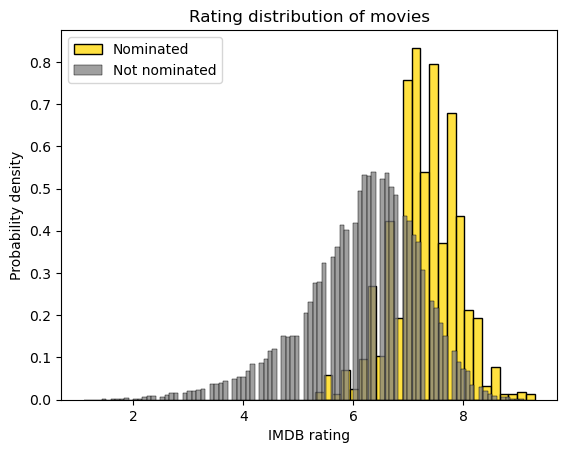

In [400]:
# Empirical CDF for nominated and not nominated 

sns.histplot(nominated, x="averageRating", stat = 'density', color = 'gold',label ='Nominated')
sns.histplot(not_nominated, x="averageRating", stat="density", color = 'grey', label = 'Not nominated')

plt.title('Rating distribution of movies')
plt.xlabel('IMDB rating')
plt.ylabel('Probability density')
plt.legend()
plt.show()


These empirical distributions look different. We use a two sample Kolmogorov-Smirnov test to test if they are different. The null hypothesis is that the observations come from the same distribution. We reject the null hypothesis if the p-value < 0.05.

In [401]:
stats.kstest(nominated['averageRating'], not_nominated['averageRating'])

KstestResult(statistic=0.5370918349017175, pvalue=1.0389776134332205e-255, statistic_location=6.8, statistic_sign=-1)

P-value = 1.0389776134332205e-255. This is small enough to safely reject the null hypothesis. We conclude that the distributions are in fact different distributions. 

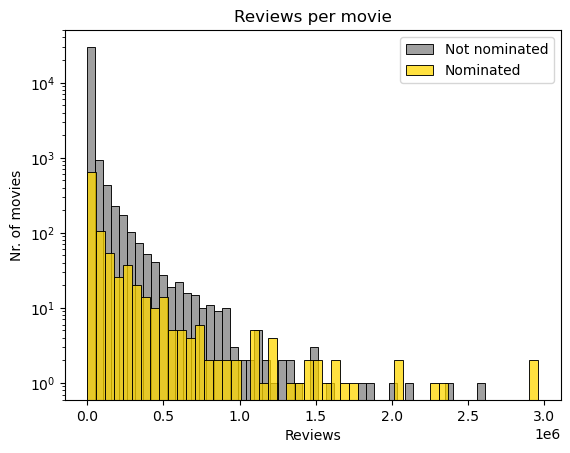

In [378]:
# Plotting reviews per IMDB reviews per movie 
sns.histplot(not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

Share of not nominated movies with fewer than 10 000 reviews 82.4 %
Share of nominated with fewer than 10 000 reviews 35.28 %


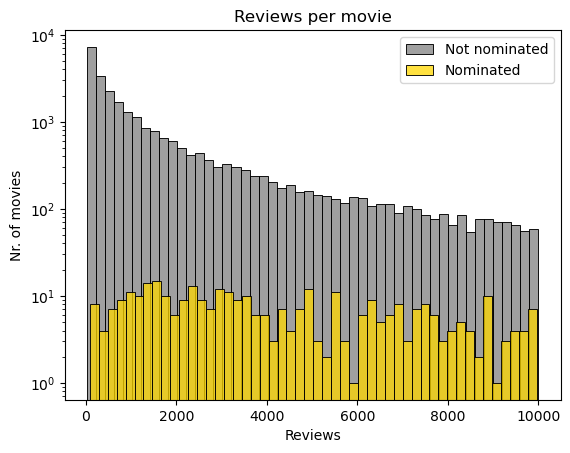

In [379]:
# As per the plot above, most movies with nominated actors have fewer than 500 000 reviews.
# We zoom in and look at the movies with few reviews. 

lim_not_nominated = not_nominated[not_nominated['numVotes'] < 10000]
lim_nominated = nominated[nominated['numVotes'] < 10000]

print('Share of not nominated movies with fewer than 10 000 reviews', round(len(lim_not_nominated)/len(not_nominated)*100,2), '%')
print('Share of nominated with fewer than 10 000 reviews', round(len(lim_nominated)/(len(nominated))*100,2),  '%')

sns.histplot(lim_not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(lim_nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')

plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

We can see that most movies with relatively few review are not nominated. 

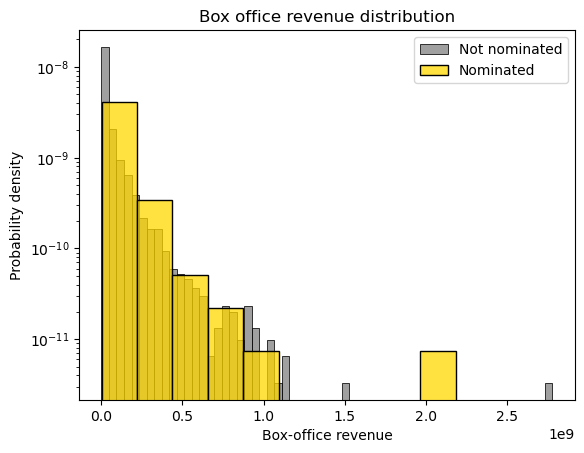

In [380]:
sns.histplot(not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 10)

plt.title('Box office revenue distribution')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Notice that the above plot is a probability distribution and that the y axis is in log scale. We are suprised since all movies with nominated actors does not seem to be the ones with the highest revenue. To investigate this we look into movies with lower box-office revenue. 

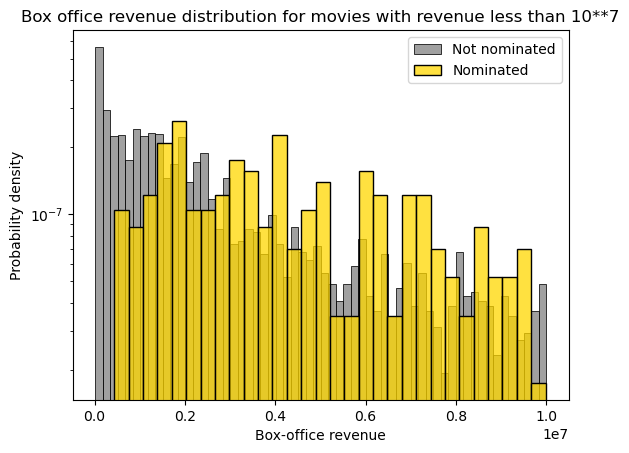

In [381]:
lim_not_nominated = not_nominated[not_nominated['box_office_revenue'] < 10**7]
lim_nominated = nominated[nominated['box_office_revenue'] < 10**7]

sns.histplot(lim_not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated', bins = 60)
sns.histplot(lim_nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated', bins = 30)

plt.title('Box office revenue distribution for movies with revenue less than 10**7')
plt.yscale('log')
plt.xlabel('Box-office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()


We can see that movies with nominated actors have revenue in an interval. They neither the movies with the highest revenue, or the movies with the lowest revenue. 

In [382]:
nominated = movie_df[movie_df['oscar_nominated'] == True]
nominated['freebase_movie_id'].value_counts()

freebase_movie_id
/m/0bj25      5
/m/04j13sx    5
/m/03mr85     5
/m/0bm2g      5
/m/0hvvf      5
             ..
/m/01vksx     1
/m/04x0wp     1
/m/015gv2     1
/m/05mxns9    1
/m/015wmg     1
Name: count, Length: 1010, dtype: int64

In [383]:
oscar_nomination_count_per_movie = nominated.groupby(["freebase_movie_id"])['freebase_movie_id'].count().to_frame().rename(columns={"freebase_movie_id": "count"})

<Axes: xlabel='count', ylabel='Density'>

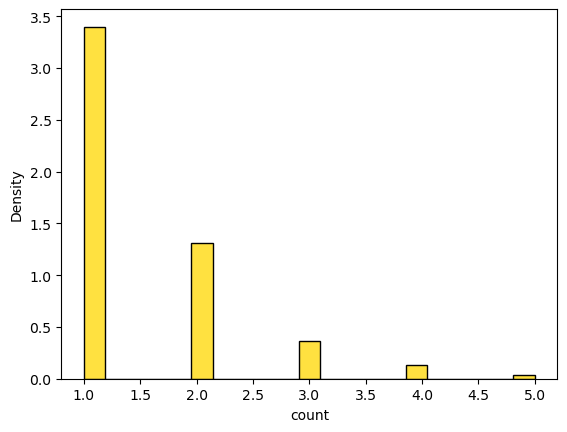

In [384]:
sns.histplot(oscar_nomination_count_per_movie, x="count", stat = 'density', color = 'gold',label ='Nominated')


In [ ]:
# Defining some variables for analysis. 
nr_movies = len(unique_movies_df)
nr_nom_movies = len(nominated.groupby('freebase_movie_id'))
nr_nominations = len(nominated)

zero_nom_movies = nr_movies - nr_nom_movies
one_nom_movies = len(oscar_nomination_count_per_movie[oscar_nomination_count_per_movie['count'] == 1])

In [386]:
# What is the probablity a movie will have a nominated actor? 
print('Likelyhood of a movie having a nominated actor: ', round(nr_nom_movies/nr_movies*100, 3), '%')

# Given that a movie has a nominated actor, what is the probablity that it will have atleast one more nominated actor? 
print('Probablity that a movie with a nominated actor will have atleast one more nominated actor', round((nr_nom_movies - one_nom_movies)/(nr_nom_movies)*100, 3), '%')


Likelyhood of a movie having a nominated actor:  1.669 %
Probablity that a movie with a nominated actor will have atleast one more nominated actor 35.248 %


<Axes: xlabel='count', ylabel='Density'>

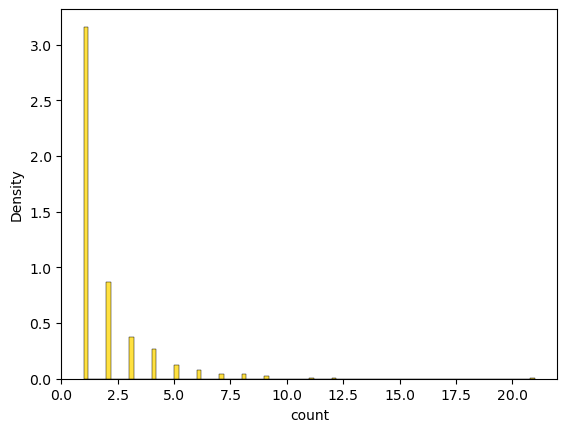

In [387]:
oscar_nomination_per_actor_name = nominated.groupby(["actor_name"])['actor_name'].count().to_frame().rename(columns={"actor_name": "count"})
sns.histplot(oscar_nomination_per_actor_name, x="count", stat = 'density', color = 'gold',label ='Nominated')
